In [1]:
import pandas as pd
from typing import List
import os

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 15
})

import pandas as pd
import os


DATA = {
        "m":            [],
        "delta_p":      [],
        "p_hat":        [],
        "p_min":        [],
        "pi":           [],
        "k":            [],
        "l":            [],
        "search_bound": [],
        "n":            [],
        "i":            [],
        "cls":          [],
    }

# m;delta_p;p_hat;p_min;pi;k;l;bound;n
def read(from_: str) -> pd.DataFrame:
    files = os.listdir(from_)
    for file in files:
        fs = file.split("_")
        i, cls = float(fs[0].split("-")[-1]), fs[-2]
        with open(os.path.join(from_, file), "r") as f:
            data = next(f.readlines()[-2:].__iter__(), "").rstrip().split(";")
            if len(data) > 1:
                n, bound, pi, delta_p, l, k, p_min, p_hat, m  = (
                    float(data[-1]), float(data[-2]), 
                    float(data[-5]), float(data[1]),
                    float(data[-3]), float(data[-4]),
                    float(data[-6]), float(data[-7]), float(data[0])
                )
                DATA["m"].append(m)
                DATA["p_min"].append(p_min)
                DATA["p_hat"].append(p_hat)
                DATA["l"].append(l)
                DATA["k"].append(k)
                DATA["pi"].append(pi)
                DATA["delta_p"].append(delta_p)
                DATA["search_bound"].append(bound)
                DATA["n"].append(n)
                DATA["i"].append(i)
                DATA["cls"].append(cls)
    return pd.DataFrame(DATA)

In [2]:
import math
from math import exp



D = "out-fdp-3-50000-600"
df = read("../out/"+D)
df.to_csv(f"../csvs/{D}.csv")


m = df.m.max()
delta_p = df.delta_p.max()
p_min = df.p_min.max()

assert m == df.m.min()
assert delta_p ==  df.delta_p.min()
assert p_min == df.p_min.min()

def find_bound_1(bound_2: int, p_hat: float, pi: float) -> int:
    r = (1-p_min) / (m-1)
    for n in range(1,math.ceil(bound_2)+1):
        l = (
            p_hat * exp(-0.5 * n * (delta_p**2) * ((1-pi)**2))
        ) + (
            (1-p_hat) * exp(-0.5 * n * ((delta_p * (1-pi)-pi)**2)) 
        ) 
        v = l <= r
        if v:
            return n
    return 0

df.sort_values(
    by=["p_hat"], 
    inplace=True, 
    ignore_index=True
)
df = df.assign(
    explicit_bound= lambda x: 
        (2 / 
         ((delta_p * (1-x.pi) - x.pi)**2)
        ) * (math.log((m-1) / (1-p_min)))
)

df["implicit_bound"] = df.apply(
    lambda x: find_bound_1(x.explicit_bound, x.p_hat, x.pi), axis=1
)
df.dropna(inplace=True)

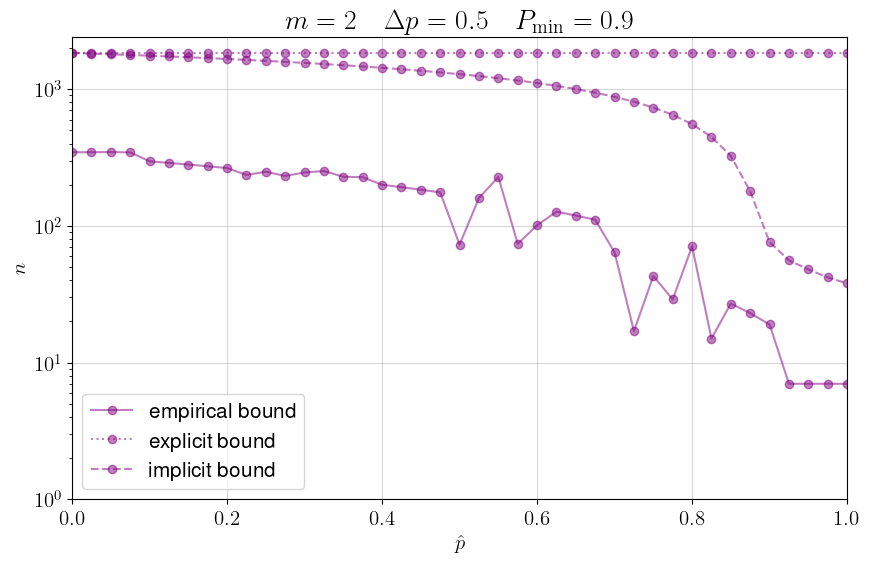

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df.p_hat, df.n, 
        "purple", 
        marker="o",
        alpha=0.5,
        label="empirical bound",
    )

ax.plot(df.p_hat, df["explicit_bound"],"purple",alpha=0.5,
        label="explicit bound",linestyle="dotted",marker="o",)
ax.plot(df.p_hat, df["implicit_bound"],"purple",alpha=0.5,
        label="implicit bound",linestyle="dashed",marker="o",)
    
plt.xlim(0, 1)
plt.ylim(1, df["search_bound"].max())
plt.yscale("log")
plt.legend()
plt.xlabel("$\hat{p}$")
plt.ylabel("$n$")
plt.title(
    '$\quad\quad m=2 \quad \Delta p = 0.5 \quad P_{\mathrm{min}} = 0.9$', 
    size=20)
plt.grid(alpha=.5)
#plt.tight_layout()
plt.savefig(f"../plots/{D}.pdf")